LDA : Linear Discriminant Analysis

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

#configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print(" Bibliothèques importées")

#load data

#loading final dataset
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f" Dataset chargé : {df.shape}")
print(f"\n Column overview :")
print(df.columns.tolist())

#check target
if 'target_class' in df.columns:
    print(f"\n Target found : {df['target_class'].nunique()} classes")
    print(df['target_class'].value_counts().sort_index())
else:
    print(" Warning: 'target_class' not found in the dataset")

#preview
print(f"\n First 5 rows preview :")
print(df.head())

# X/y and train/test split
print("=" * 60)
print("PREPARATION : Split X/y and Train/Test Split")
print("=" * 60)

#separation of features and target
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])

#removing city_label if present
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nFeatures (X) : {X.shape[1]} columns")
print(f"Target (y) : {len(y)} values")
print(f"\nClass distribution :")
print(y.value_counts().sort_index())

#stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n Split done :")
print(f"  Train : {X_train.shape}")
print(f"  Test  : {X_test.shape}")
print(f"\nTrain distribution :")
print(y_train.value_counts().sort_index())
print(f"\nTest distribution :")
print(y_test.value_counts().sort_index())


 Bibliothèques importées
 Dataset chargé : (73111, 30)

 Column overview :
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

 Target found : 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

 First 5 rows preview :
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                

Accuracy: 48.61%
Confusion matrix: 
[[2421  918  407   77]
 [1121 1197  911  261]
 [ 580  788 1441  851]
 [ 334  362  905 2049]]


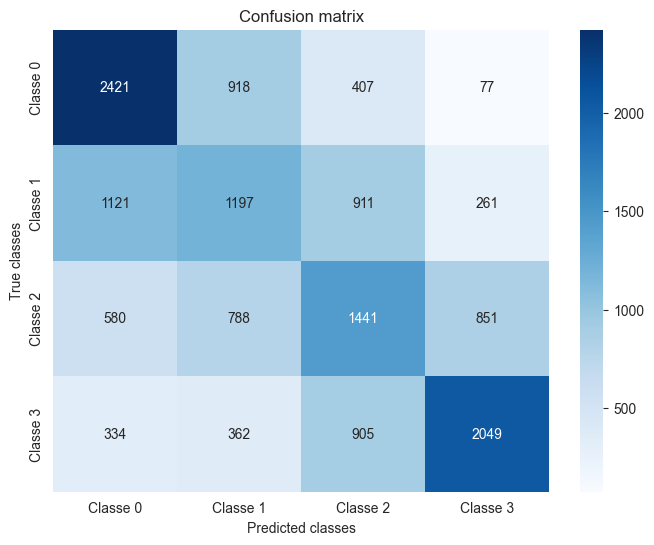

In [12]:
#LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#test set predicted classes
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix: \n{cm}")

#visualization 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Classe {i}' for i in range(4)],
            yticklabels=[f'Classe {i}' for i in range(4)])
plt.title('Confusion matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()


This matrix shows that the data is already able to spot extremes, even if the middle ground is still a bit confusionary. The model can easily identify the cheapest apartments (Class 0: 2421 correct) and the most expensive ones (Class 3: 2049 correct) because of their distinct features. There is a significant overlap between Classes 1 and 2.


LDA Method
Reduced dimensions: 27 → 3
Explained variance: [0.90665568 0.08597618 0.00736814]


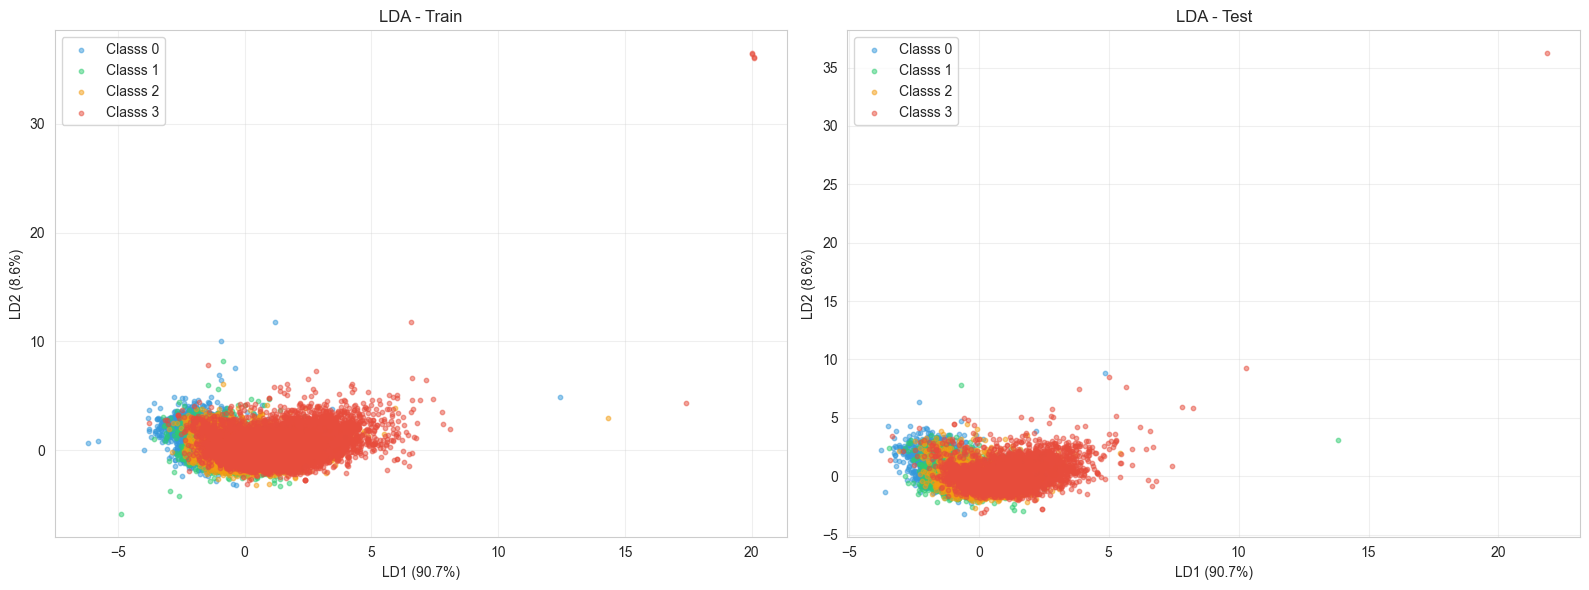

In [13]:
#LDA
colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

print("\n" + "=" * 60)
print("LDA Method")
print("=" * 60)

lda = LinearDiscriminantAnalysis(n_components=3) #3 composantes pour 4 classes
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print(f"Reduced dimensions: {X_train.shape[1]} → {X_train_lda.shape[1]}")
print(f"Explained variance: {lda.explained_variance_ratio_}")

#2D visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (X_lda, y_set, title) in zip(axes, 
    [(X_train_lda, y_train, 'Train'), (X_test_lda, y_test, 'Test')]):
    
    for classe in range(4):
        mask = y_set == classe
        ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                  c=colors_class[classe], label=f'Classs {classe}', alpha=0.5, s=10)
    
    ax.set_title(f"LDA - {title}")
    ax.set_xlabel(f"LD1 ({lda.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"LD2 ({lda.explained_variance_ratio_[1]:.1%})")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The plots reveal a clean color transition along the first axis, which carries 90.7% of the model's discriminatory power. The price classes, shifting from blue to red, follow a very orderly sequence, proving that Paris apartment prices follow a strong linear logic. 

The second axis accounts for only 8.6% of the useful information for separating the classes. Visually, this creates a "squashed" effect: the data points are widely spread out horizontally but tightly bunched vertically. This tells us that the variables truly distinguishing a "budget" apartment from a "luxury" one are almost entirely captured by LD1, likely taking into account square footage and neighborhood, while other features don't contribute much to refining the classification.

The striking similarity between the Train and Test plots confirms that the model is robust and isn't suffering from overfitting. You can also spot a few isolated points on the far right: these are outliers representing the ultra-luxury segment of the Paris market. Their distance from the rest of the pack shows just how different these properties are from the standard market.

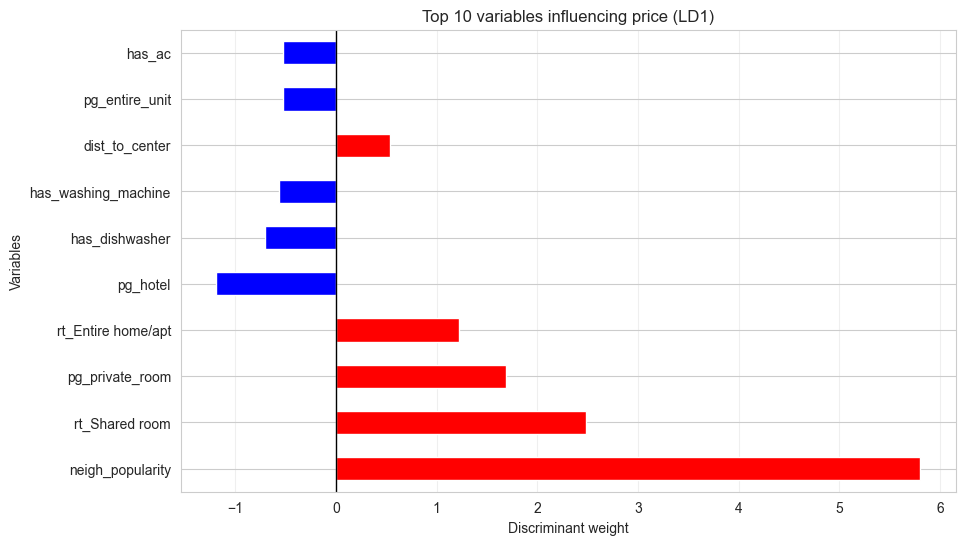

In [14]:
#LD1 coefficients 
coeffs_ld1 = pd.Series(lda.coef_[0], index=X.columns)

#sorting
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10) #top 10 features
top_coeffs = coeffs_ld1.loc[top_features.index]

#plot
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 variables influencing price (LD1)")
plt.xlabel("Discriminant weight")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()


The analysis demonstrates that the real estate market is structured in a linear ways. The clear visual separation between groups, confirmed by the test data, proves the model's robustness and identifies neighborhood popularity and accommodation type as the primary drivers of value. While the middle market segments show some similarities, luxury properties stand out radically.

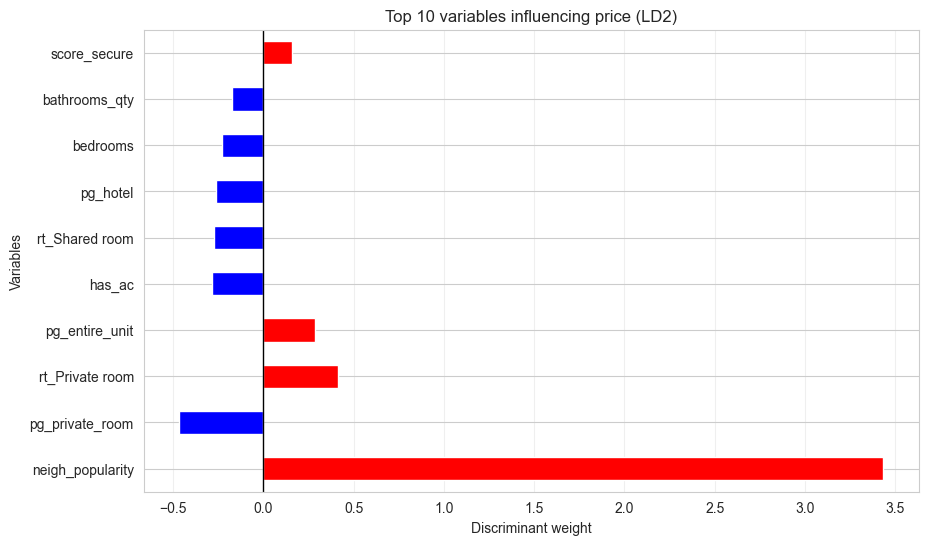

In [15]:
#LD2 coefficients 
coeffs_ld1 = pd.Series(lda.coef_[1], index=X.columns)

#sorting
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10)
top_coeffs = coeffs_ld1.loc[top_features.index]

#plot
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 variables influencing price (LD2)")
plt.xlabel("Discriminant weight")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()


While the second axis is secondary accounting for only 8.6% of the explained variance it reveals several nuances that complement the geographic dimension. Although neighborhood popularity remains a dominant positive factor, this axis is distinguished by the negative influence of variables related to capacity, such as the number of bedrooms or bathrooms. This suggests that LD2 captures a contrast between highly popular but potentially smaller units and larger properties whose value isn't purely location driven. 

In [16]:
#LDA coordinates
lda_coords = pd.DataFrame(X_train_lda, columns=[f'LD{i+1}' for i in range(X_train_lda.shape[1])])

#correlations between X_train and the LD axes
structure_matrix = pd.concat([X_train.reset_index(drop=True), lda_coords], axis=1).corr()
final_corr = structure_matrix.loc[X.columns, ['LD1', 'LD2']]

print(final_corr)


                             LD1       LD2
accommodates            0.835905  0.100482
bedrooms                0.791398  0.294905
beds                    0.575632  0.114134
minimum_nights_avg_ntm -0.161780  0.209805
number_of_reviews      -0.115761 -0.089139
dist_to_center         -0.043559  0.302325
bathrooms_qty           0.564270  0.543842
has_ac                  0.314972  0.017732
has_elevator            0.175487 -0.060298
has_dishwasher          0.442307 -0.318149
has_parking             0.107539  0.028797
has_balcony             0.138188 -0.025842
has_washing_machine     0.285634 -0.226646
standing_thermal        0.297028 -0.045701
score_chef_kitchen      0.190397 -0.251545
score_coffee            0.115681 -0.202839
score_wellness          0.304956  0.048095
score_work              0.191816 -0.069765
score_view              0.065100 -0.019255
score_secure           -0.117640 -0.283637
neigh_popularity       -0.198406  0.027439
pg_entire_unit          0.165839 -0.329068
pg_hotel   

The LD1 axis is (unsurprisingly) driven by guest capacity and property size, showing strong correlations for accommodates (0.84) and bedrooms (0.79). This confirms that the primary factor in the Paris real estate pricing is derives from physical space. In contrast, the LD2 axis captures an interesting relatioshinp between management style and configuration. It correlates positively with private rooms and distance from the city center, while showing a negative relationship with entire homes and specific amenities like dishwashers.

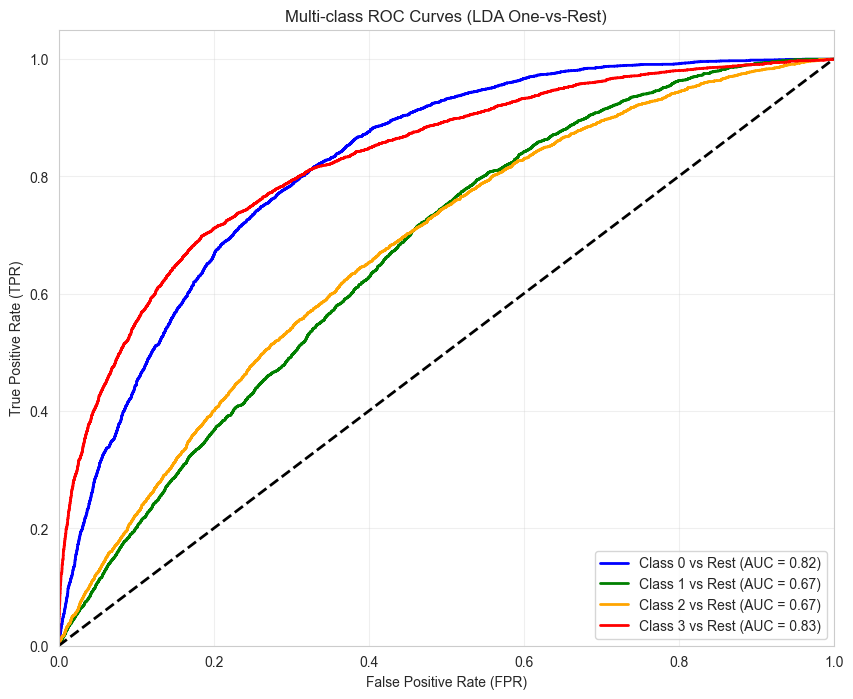

In [17]:
#ROC curves
#one vs rest per class to evaluate performance by quartile

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#binarize the target 
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

#get predicted probabilities from LDA
y_score = lda.predict_proba(X_test)

#compute and plot curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {i} vs Rest (AUC = {roc_auc:.2f})')

#chart styling
plt.plot([0, 1], [0, 1], 'k--', lw=2) #randomization
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curves (LDA One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


The ROC curves confirm the model’s predictive power, especially for the extreme ends of the market. Classes 0 and 3 display the most convex curves and the highest AUC scores, indicating that the model isolates these categories from the rest of the dataset efficiently. However, Classes 1 and 2 show slightly lower performance with curves closer to the confusion matrix observed earlier. 